In [1]:
from __future__ import division, unicode_literals, print_function # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import resize

# change the following to %matplotlib notebook for interactive plotting
%matplotlib widget

# Optionally, tweak styles.
mpl.rc('figure', figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [2]:
import os
import numpy as np

# import the packages for reading images and particle tracking
from skimage import io
import trackpy as tp

In [3]:
def crop(img):
    """
    Crop the image to select the region of interest
    """
    x_min = 0
    x_max = -1
    y_min = 0
    y_max = -1
    return img[y_min:y_max,x_min:x_max]

In [42]:
# Set the directory path
glacier_path = 'Z:\Mingxuan Liu'

# The folder where the .tif image stack exists
folder_name = 'tetramer-pl-wc-1-6fps'

# The file needed to be read
file_name = folder_name + '-binary-crop.tif'

# Join the directory path, folder name, and file name to locate .tif images
tif_path = os.path.join(glacier_path, folder_name, file_name)

frames = io.imread(tif_path)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


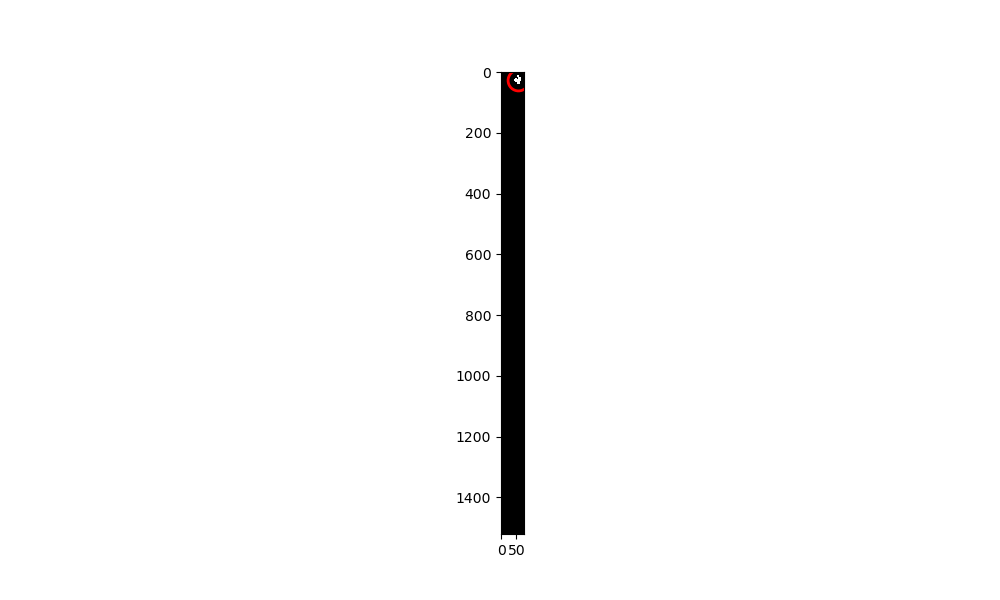

In [43]:
# manually check the binary cropped image
fr = 0
# tracking parameters
params = {
    'diameter': 47,
    'minmass': 3000,
    'invert': False,
    'separation': 15,
}
f = tp.locate(frames[fr], **params);
plt.figure()
image = tp.annotate(f, frames[fr]);

In [44]:
# process particle tracking for all frames
data = tp.batch(frames, **params);

Frame 491: 1 features


In [45]:
# Link the particles in each frame to their positions in previous two frames
link_data = tp.link(data,15,memory=3)

# Group by 'frame' and count the number of particles in each group
group_sizes = link_data.groupby('frame').size()
# Find frames where no particle is identified
no_particle_frames = group_sizes[group_sizes < 1]
# Find frames where more than one particle is identified
more_particle_frames = group_sizes[group_sizes > 1]
# Print the frame numbers
print("Frames below have identified no particle:")
print(no_particle_frames.index.tolist())
print("Frames below have identified more than one particle:")
print(more_particle_frames.index.tolist())

Frame 491: 1 trajectories present.
Frames below have identified no particle:
[]
Frames below have identified more than one particle:
[]


In [46]:
print(link_data)
link_data.to_csv(os.path.join(glacier_path, folder_name, folder_name + ' binary.csv'))

               y          x          mass      size       ecc      signal  \
0      25.812052  55.297660  79024.095703  9.692615  0.060094  210.168267   
1      54.830401  54.643194  74510.101961  9.244806  0.074743  211.168627   
2      57.813567  54.462005  74538.368627  9.026857  0.079532  211.168627   
3      60.514755  54.629179  72831.800000  8.961960  0.090238  213.000000   
4      63.485144  54.600749  72702.329412  8.854085  0.082503  213.000000   
..           ...        ...           ...       ...       ...         ...   
467  1482.075239  21.973313  73600.341280  8.889279  0.191837  212.951868   
468  1488.122290  21.776641  73871.425741  8.885873  0.223854  212.960562   
469  1490.970433  21.711331  74485.992157  8.941215  0.236921  211.168627   
470  1494.003006  21.564155  74167.900249  8.981034  0.242364  212.960562   
471  1496.950043  21.548970  74865.942113  9.119176  0.244947  212.979185   

     raw_mass   ep  frame  particle  
0    104295.0  0.0      0         0  